# Resolución de laberintos.
### Autor: Saúl Sosa Díaz


---
## El problema básico.
Consideremos un grafo $G = (V, A)$ que simboliza un laberinto. En este grafo, el nodo 1 representa la salida del laberinto. Además, el nodo n es la salida del laberinto. Donde cada intersección es un nodo y cada pasillo es una arista. Resolver el laberinto consiste en encontrar un camino desde un nodo de inicio (punto de entrada) a un nodo objetivo (punto de salida). 

Si añadimos una arista desde el nodo n al nodo 1 podemos encontrar un circuito que los comunique.




## Resolución del problema.
Importamos los paquetes necesarios.

In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Graphs")
Pkg.add("LightGraphs")
Pkg.add("LightGraphsFlows")
Pkg.add("GraphRecipes")
Pkg.add("GraphPlot")
Pkg.add("Plots")
Pkg.add("Compose")
Pkg.add("Cairo")
Pkg.add("Colors")

using JuMP, GLPK, LightGraphs, LightGraphsFlows, Graphs, GraphPlot, Random, Compose, Cairo, Colors, Printf, Random, Test, LinearAlgebra



   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Chan

### Introducimos los datos.

In [2]:
# Set the seed for reproducibility
Random.seed!(1234)
function readRandomInstance(N)
    coord = rand( 0:1000 , N, 2)
    cost  = zeros( Int32, N, N)
    for i=1:N, j=1:N
        cost[i,j]=round(sqrt((coord[i,1]-coord[j,1])^2+(coord[i,2]-coord[j,2])^2),digits=0)
    end
    return N,coord,cost
end

function IsInteger(N,sol)
    for i=1:N,j=1:N
        if EPS < sol[i,j] < 1-EPS
            return false
        end
    end
    return true
end


N = 8
C = [
    0 0 1 0 0 1 0 0;
    0 0 0 1 0 0 0 0;
    0 1 0 0 1 0 1 0;
    0 0 0 0 1 1 0 1;
    0 0 1 1 0 0 0 0;
    0 0 0 0 0 0 0 0;
    0 1 0 0 0 1 0 0;
    1 0 1 0 1 1 1 0
   ]
   


8×8 Matrix{Int64}:
 0  0  1  0  0  1  0  0
 0  0  0  1  0  0  0  0
 0  1  0  0  1  0  1  0
 0  0  0  0  1  1  0  1
 0  0  1  1  0  0  0  0
 0  0  0  0  0  0  0  0
 0  1  0  0  0  1  0  0
 1  0  1  0  1  1  1  0

Mostramos el mapa visualmente. Y el horario de apertura de los planetas

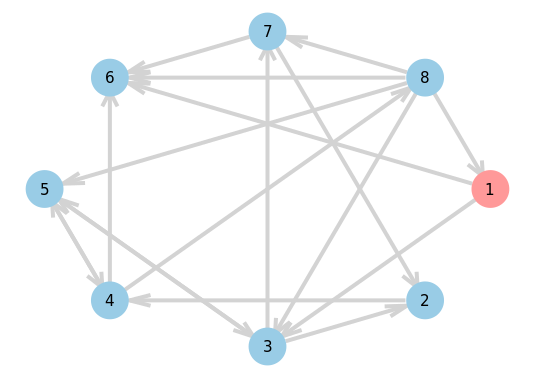

In [3]:
function PlotGraph(N, Costs)
    EPS = 0.00001
    G = Graphs.SimpleDiGraph(N)
    # Add the edges to the graph
    for i=1:N, j=1:N
        if Costs[i,j] > EPS
            Graphs.add_edge!(G,i,j)
        end
    end
    # Change the color of the first node to a pastel red, and the rest to a pastel blue.
    pastel_red = RGB(1.0, 0.6, 0.6)
    pastel_blue = RGB(0.6, 0.8, 0.9)
    node_colors = [pastel_red; fill(pastel_blue, N-1)]
    
    # Plot the graph
    p = gplot(G, nodelabel = 1:N, layout = circular_layout, nodefillc = node_colors)
    display(p)
    return
end

function AdjTour(N,sol)
    EPS = 0.00001
    pred = zeros(Int32,N)
    next = zeros(Int32,N)
    for i=1:N, j=1:N
        if sol[i,j] > EPS
            pred[j] = i
            next[i] = j
        end
    end
    return pred,next
end

function PrintTour(N,sol)
    pred,next = AdjTour(N,sol)
    print("Tour: ")
    u = 1
    v = next[u]
    while v!=1
        print("$(u) => ")
        u = v
        v = next[u]
    end
    println("$(u)")
end


PlotGraph(N, C)

### Construir el modelo.

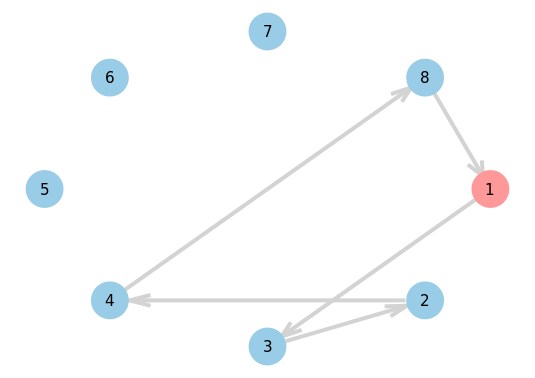

Pasos mínimos: 5.0
Tour: 1 => 3 => 2 => 4 => 8


In [4]:
function SolveMaze()
    EPS = 0.00001
    model = Model(GLPK.Optimizer)
    set_silent(model)

    # Variables
    @variable(model, x[1:N,1:N], Bin)
    @objective(model, Min, sum(C[i,j] * x[i,j] for i in 1:N, j in 1:N))

    for i in 1:N
        for j in 1:N
            if C[i,j] == 0
                set_upper_bound(x[i,j], 0)
            end
        end
    end

    @constraint(model, sum(x[1,:]) == 1)  # Sale exactamente una vez del nodo 1
    @constraint(model, sum(x[:,1]) == 1)  # Llega exactamente una vez al nodo 1
    for i in 2:N
        @constraint(model, sum(x[i,:]) - sum(x[:,i]) == 0)
    end
    
    optimize!(model)
    # Show solutions
    PlotGraph(N,value.(x))
    println("Pasos mínimos: $( ceil(objective_value(model)-EPS) )")
    PrintTour(N, value.(x))
end
SolveMaze()